In [1]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

  # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#set path to Features CSV and read in CSV
aapl_df = pd.read_pickle('Resources/aapl_features_df.pickle')
aapl_df.head()

,aapl Close,aapl Volume,Call Volume,Put Volume,Total Option Volume,Percent of Puts,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns,sent_by_sentence_score,sentiment neg,sentiment pos,sentiment score
2019-08-05,193.22,44910342,405627.0,373180.0,778807.0,0.479169,False,0.520831,False,204.722925,...,1.410513,1.0,1.773845,1.410513,1.0,-0.053261,-0.5994,-1,0,-1
2019-08-06,196.98,31922123,319702.0,219420.0,539122.0,0.406995,False,0.593005,False,204.571425,...,1.436669,1.0,1.226958,1.436669,1.0,0.019460,0.2732,0,1,1
2019-08-07,199.14,29096670,285495.0,223024.0,508519.0,0.438576,False,0.561424,False,204.467425,...,1.459872,0.0,1.125804,1.459872,0.0,0.010966,0.7030,0,1,1
2019-08-08,203.45,23184966,586947.0,354648.0,941595.0,0.376646,False,0.623354,True,204.479425,...,1.470834,0.0,1.952782,1.470834,0.0,0.021643,-0.4404,-1,0,-1
2019-08-09,200.93,21549074,261899.0,255741.0,517640.0,0.494052,False,0.505948,False,204.438925,...,1.476128,0.0,1.053826,1.476128,0.0,-0.012386,0.9261,0,1,1


In [3]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [4]:
#add daily change rates to increase the staionarity of dataset
trading_signals_df['volume delta'] = aapl_df['aapl Volume'].dropna().pct_change()
trading_signals_df['bb std delta'] = aapl_df['bollinger_std'].dropna().pct_change()
trading_signals_df['rvol delta'] = aapl_df['rvol'].dropna().pct_change()
trading_signals_df['option rvol delta'] = aapl_df['Option rVol'].dropna().pct_change()
trading_signals_df['sentiment'] = aapl_df['sent_by_sentence_score'].fillna(0).pct_change()

#add daily returns as target
trading_signals_df['daily returns'] = aapl_df['daily returns'].dropna()

trading_signals_df= trading_signals_df.fillna(value = 0)
trading_signals_df= trading_signals_df.replace([np.inf, -np.inf], 0.0)
trading_signals_df.head()

,volume delta,bb std delta,rvol delta,option rvol delta,sentiment,daily returns
2019-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053261
2019-08-06,-0.289203,0.060823,-0.306222,-0.308306,-1.455789,0.019460
2019-08-07,-0.088511,0.026612,-0.112735,-0.082443,1.573206,0.010966
2019-08-08,-0.203175,-0.000778,-0.217842,0.734567,-1.626458,0.021643
2019-08-09,-0.070558,0.007159,-0.082239,-0.460347,-3.102861,-0.012386


In [5]:
 def window_data(window):
    """
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(trading_signals_df) - window):
        features = trading_signals_df.iloc[i : (i + window), :]
        target = trading_signals_df.iloc[(i + window), -1]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Define the window size
window_size = 7

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(window_size)



In [7]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])



In [9]:
scaler = MinMaxScaler()
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Define the Transformer model.
model = Sequential()

# Initial model setup
number_units = 7
dropout_fraction = 0.3
inputs = len(trading_signals_df.columns)

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X.shape[1], inputs))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [11]:
# Compile the LSTM model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 7)              392       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 7)              420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

In [13]:
 # Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0)

In [14]:
 # Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [15]:
#Recover the original, nonscaled prices
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [16]:
# Create a DataFrame of Real and Predicted values, shifted by forward window
shift =7
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = trading_signals_df.index[-len(real_prices)-shift:-shift ] )


# Show the DataFrame's head
stocks

,Actual,Predicted
2019-11-12,-0.004597,0.002498
2019-11-13,-0.000649,0.002918
2019-11-14,0.017492,0.001523
2019-11-15,-0.008708,0.001594
2019-11-18,0.014388,0.000507
2019-11-19,-0.002687,0.000453
2019-11-20,-0.011565,0.000458
2019-11-21,-0.017305,0.000289
2019-11-22,0.008554,0.000388
2019-11-25,0.014671,0.000576


In [17]:
#convert stocks df into positive and negative signals
stocks['Positive Actual signal'] = np.where(stocks['Actual'] > 0, 1, 0)
stocks['Negative Actual signal'] = np.where(stocks['Actual'] < 0, -1, 0)

stocks['Positive Predicted signal'] = np.where(stocks['Predicted'] > 0, 1, 0)
stocks['Negative Predicted signal'] = np.where(stocks['Predicted'] < 0, -1, 0)

#merge to create one column per signal, shifted back to reflect forward projection window
shift = 7
stocks['Actual Signal'] = stocks['Positive Actual signal'] + stocks['Negative Actual signal']
stocks['LSTM Predicted Signal'] = stocks['Positive Predicted signal'] + stocks['Negative Predicted signal']
stocks

,Actual,Predicted,Positive Actual signal,Negative Actual signal,Positive Predicted signal,Negative Predicted signal,Actual Signal,LSTM Predicted Signal
2019-11-12,-0.004597,0.002498,0,-1,1,0,-1,1
2019-11-13,-0.000649,0.002918,0,-1,1,0,-1,1
2019-11-14,0.017492,0.001523,1,0,1,0,1,1
2019-11-15,-0.008708,0.001594,0,-1,1,0,-1,1
2019-11-18,0.014388,0.000507,1,0,1,0,1,1
2019-11-19,-0.002687,0.000453,0,-1,1,0,-1,1
2019-11-20,-0.011565,0.000458,0,-1,1,0,-1,1
2019-11-21,-0.017305,0.000289,0,-1,1,0,-1,1
2019-11-22,0.008554,0.000388,1,0,1,0,1,1
2019-11-25,0.014671,0.000576,1,0,1,0,1,1


In [18]:
stocks['LSTM Predicted Signal'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\aapl_LSTM_signals_df.pickle')

<AxesSubplot:>

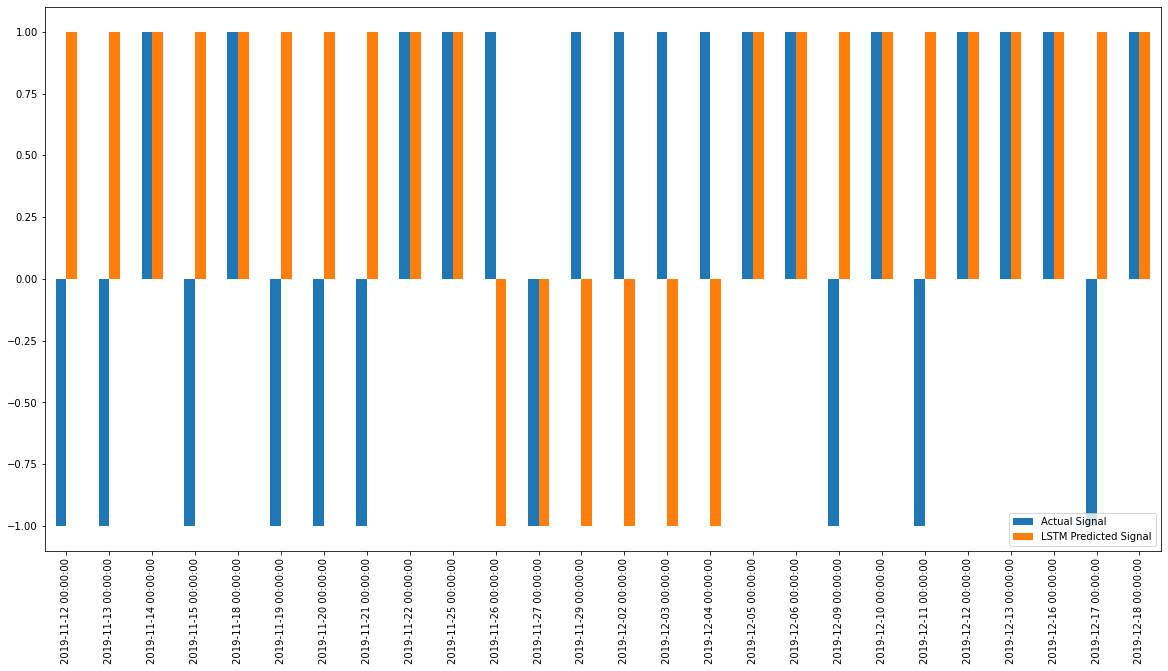

In [19]:
stocks.plot(y = ['Actual Signal', 'LSTM Predicted Signal'], figsize = (20,10), kind = 'bar')

<AxesSubplot:>

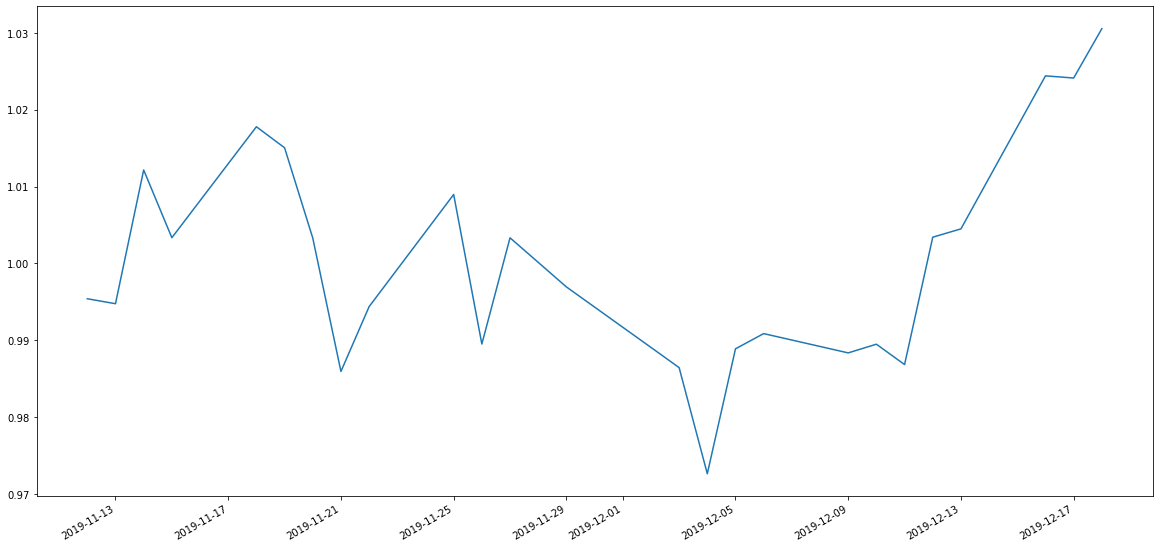

In [20]:
# Calculate cumulative return of model and plot the result
(1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod().plot(figsize = (20,10))

<AxesSubplot:>

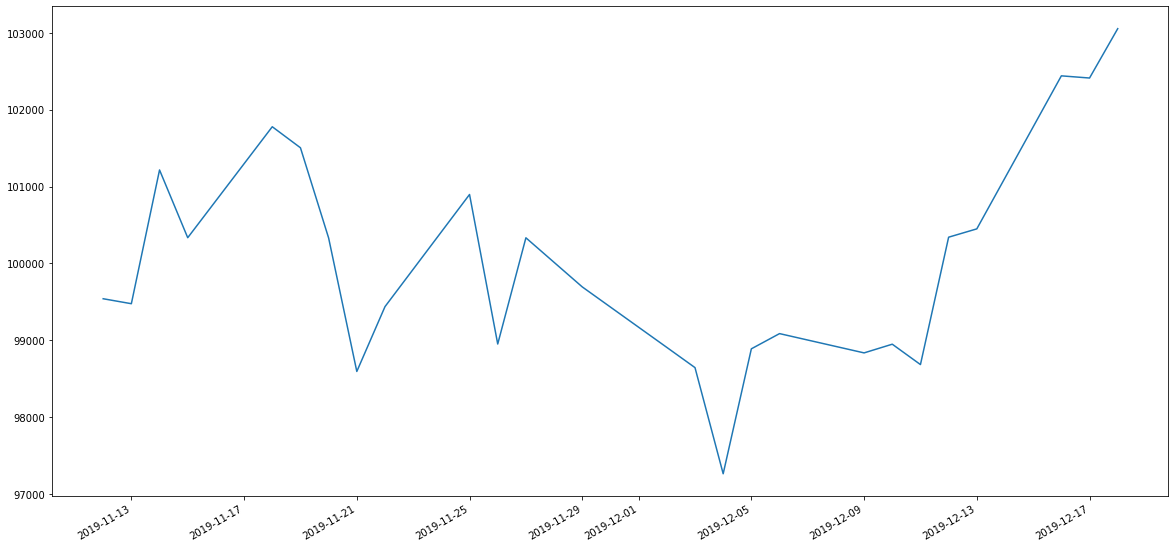

In [21]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod()
cumulative_return_capital.plot(figsize = (20,10))